In [37]:
import pandas as pd

returns = pd.read_pickle('Data/long_short_returns.pkl')
hhi = pd.read_pickle('Data/HHI.pkl')
etf_share = pd.read_pickle('Data/etf_share.pkl')
hhi_series = hhi.pivot(index='date', columns='industry', values='HHI')
returns = returns.squeeze()
mktcap = hhi.pivot(index='date', columns='industry', values='Industry_MktCap')

industry,"Agriculture, Forestry, and Fishing",Construction,"Finance, Insurance, and Real Estate",Manufacturing,Mining,Public Administration,Retail Trade,Services,Technology,Transportation and Public Utilities,Wholesale Trade
date,,,,,,,,,,,
1960-01-01,NaN,0.525015,0.206504,0.029450,0.235143,NaN,0.082495,0.346117,0.159953,0.218986,0.376020
1960-02-01,NaN,0.526143,0.204302,0.029028,0.236229,NaN,0.084197,0.347594,0.156936,0.218528,0.406999
1960-03-01,NaN,0.523502,0.203902,0.029307,0.235690,NaN,0.085229,0.357539,0.166303,0.222037,0.408856
1960-04-01,NaN,0.517372,0.203718,0.029585,0.231987,NaN,0.083971,0.356715,0.171305,0.230184,0.425724
1960-05-01,NaN,0.508150,0.196983,0.028826,0.232880,NaN,0.087137,0.366629,0.169990,0.243415,0.429298


In [20]:
weights = mktcap.div(mktcap.sum(axis=1), axis=0)
vw_hhi = (hhi_series * weights).sum(axis=1)
vw_hhi.name = 'vw_hhi'
vw_hhi = vw_hhi.dropna()
vw_hhi.head()

date
1960-01-01    0.096311
1960-02-01    0.096763
1960-03-01    0.098573
1960-04-01    0.101176
1960-05-01    0.102688
Name: vw_hhi, dtype: float64

In [22]:
print(hhi_series.index.equals(weights.index))  # Should be True
print(hhi_series.columns.equals(weights.columns))  # Should be True


True
True


In [57]:
df = pd.concat([returns, vw_hhi, etf_share], axis=1).dropna()
df.columns = ['returns', 'vw_hhi', 'etf_share']

<Axes: title={'center': 'Rolling Correlation (5 years)'}>

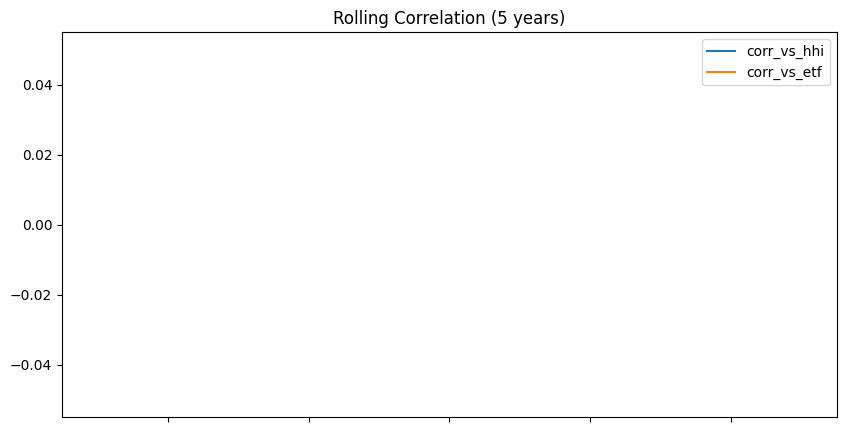

In [56]:
df['corr_vs_hhi'] = df['returns'].rolling(60).corr(df['vw_hhi'])
df['corr_vs_etf'] = df['returns'].rolling(60).corr(df['etf_share'])

df[['corr_vs_hhi', 'corr_vs_etf']].plot(title='Rolling Correlation (5 years)', figsize=(10,5))


In [62]:
import statsmodels.api as sm

X = df[['vw_hhi', 'etf_share']]
X = sm.add_constant(X)
y = df['returns']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.600
Date:                Wed, 18 Jun 2025   Prob (F-statistic):              0.204
Time:                        17:43:10   Log-Likelihood:                 650.29
No. Observations:                 306   AIC:                            -1295.
Df Residuals:                     303   BIC:                            -1283.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.008      0.744      0.4

In [63]:
df['post2008'] = (df.index >= '2008-09-01').astype(int)

# Interaction terms
df['hhi_post'] = df['vw_hhi'] * df['post2008']
df['etf_post'] = df['etf_share'] * df['post2008']

X = df[['vw_hhi', 'etf_share', 'post2008', 'hhi_post', 'etf_post']]
X = sm.add_constant(X)

model = sm.OLS(df['returns'], X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6536
Date:                Wed, 18 Jun 2025   Prob (F-statistic):              0.659
Time:                        17:43:59   Log-Likelihood:                 650.34
No. Observations:                 306   AIC:                            -1289.
Df Residuals:                     300   BIC:                            -1266.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.010      0.590      0.5

In [64]:
from statsmodels.tsa.api import VAR

var_df = df[['returns', 'vw_hhi', 'etf_share']]
var_model = VAR(var_df).fit(maxlags=4, ic='aic')
var_model.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Jun, 2025
Time:                     17:44:23
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -26.5267
Nobs:                     304.000    HQIC:                  -26.6808
Log likelihood:           2798.02    FPE:                2.33388e-12
AIC:                     -26.7835    Det(Omega_mle):     2.17981e-12
--------------------------------------------------------------------
Results for equation returns
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.006506         0.008039            0.809           0.418
L1.returns           0.201959         0.060806            3.321           0.001
L1.vw_hhi           -3.376309         1.064935           -3.17